# Optimize the Accuracy of Document Retrival

In this example, we build a three-hop document retrival workflow for [HoVer](https://arxiv.org/abs/2011.03088). The workflow gathers related context to verify a given claim. We aim to improve the f1-score over the retrieved documents.

The workflow two types of agents (4 in total):
- **Query agent**: generates a search query for retrieval.
- **Summarize agent**: extract useful points in the given documents.

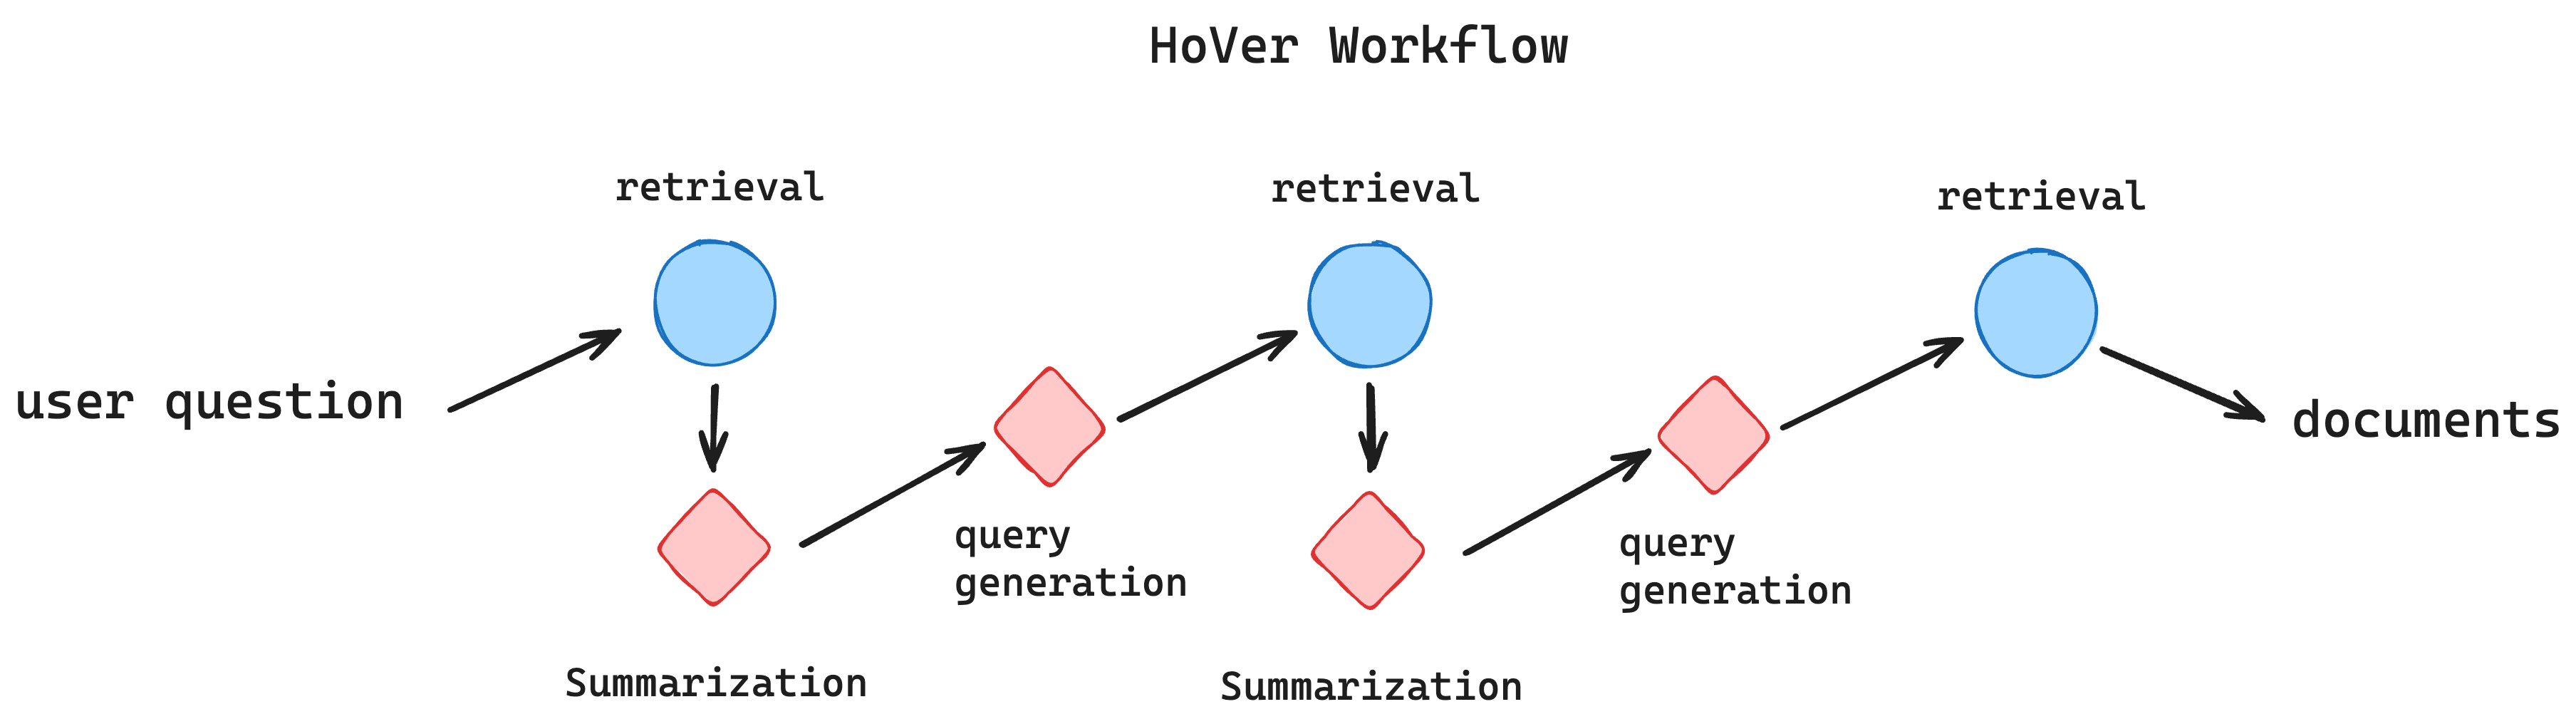

## 1) Setup

First, let's set the environment for workflow execution. Following keys are required:

- OPENAI_API_KEY="your-openai-key"
- COLBERT_URL="colbert-serving-url"

> **Note:** 
>
> If you are using DSPy's ColBERT service, try link `http://20.102.90.50:2017/wiki17_abstracts`. 
>
> For hosting on your local machine, check [ColBERT official repo](https://github.com/stanford-futuredata/ColBERT) for installation and setup.

## 2) Check Hover Workflow

The complete code for this workflow is based on `dspy` and is avaibale in `workflow.py`. 

The workflow returns the `pid` of all retrieved passages, which will be used to calcuate the f1-score.

Try it out with:

In [1]:
%run workflow.py

{'pred_docs': (670219, 821694, 1513707, 4434531, 4751601, 670219, 813146, 821694, 821694, 1722727)}


## 3) Optimize The Workflow

The workflow entry point is already registered using annotation `cognify.register_opt_workflow`.

Here we configure the optimization pipeline:
1. Define the evaluation method
2. Define the data loader
3. Config the optimizer

### 3.1 Use F1 as the retrieval metric

We use builtin `f1_score_set` to measure the overlap between retrieved documents and the ground truth.

In [2]:
import cognify

@cognify.register_opt_score_fn
def doc_f1(pred_docs, gold_docs):
    pred_docs = set(pred_docs)
    gold_docs = set(gold_docs)
    return cognify.metric.f1_score_set(pred_docs, gold_docs)

### 3.2 Load the Data

We provide the example data in `qas._json` file for you to start with.

In [3]:
!head -n 1 qas._json

{"qid":0,"question":"Skagen Painter Peder Severin Kr\u00f8yer favored naturalism along with Theodor Esbern Philipsen and the artist Ossian Elgstr\u00f6m studied with in the early 1900s.","support_pids":[670219,1513707,811545],"support_facts":[[670219,0],[670219,1],[1513707,1],[811545,2]],"support_titles":["Kristian Zahrtmann","Peder Severin Kr\u00f8yer","Ossian Elgstr\u00f6m"],"num_hops":3,"label":1,"uid":"330ca632-e83f-4011-b11b-0d0158145036","hpqa_id":"5ab7a86d5542995dae37e986"}


The data should be formatted to align with the function signature of both the workflow entry point and the evaluator.

Signatures are:
- workflow (claim) -> {'pred_docs': ...}
- evaluator (pred_docs, gold_docs) -> float

Thus the dataloader should provide a tuple of dictionaries like this:
```python
(
    {'claim': ...},
    {'gold_docs': ...},
)
```

The complete data loader code is provided below.

In [4]:
train_size = 100
val_size = 50
dev_size = 200
data_path = 'qas._json'
seed = 0

import json
import random

@cognify.register_data_loader
def load_data():
    data = []
    
    # only include difficult examples with 3 hops
    with open(data_path, 'r') as file:
        for line in file:
            obj = json.loads(line)
            if obj['num_hops'] == 3:
                data.append(obj)
                
    rng = random.Random(seed)
    rng.shuffle(data)
    
    def formatting(x):
        input = {'claim': x['question']}
        ground_truth = {'gold_docs': x['support_pids']}
        return (input, ground_truth)
    
    train_set = data[:train_size]
    val_set = data[train_size:train_size+val_size]
    dev_set = data[train_size+val_size:train_size+val_size+dev_size]
    
    train_set = [formatting(x) for x in train_set]
    val_set = [formatting(x) for x in val_set]
    dev_set = [formatting(x) for x in dev_set]
    return train_set, val_set, dev_set

### 3.3 Config the optimizer

Let's use the default configuration to optimize this workflow. The search space includes:
- 2 fewshot examples to add for each agent
- whether to apply Chain-of-thought to each agent

This workflow invokes many agents, we set the parallel level to `50` to accelerate the process. Please check your OpenAI rate limit and set accordingly.

In [5]:
from cognify.hub.search import default

search_settings = default.create_search(evaluator_batch_size=50)

## 4 Start the Optimization

You can save the above configs in `config.py` file and use Cognify's CLI to fire the optimization with:

```console
$ cognify optimize workflow.py
```

Alternatively you can run the following:

In [ ]:
train, val, dev = load_data()

opt_cost, pareto_frontier, opt_logs = cognify.optimize(
    script_path="workflow.py",
    control_param=search_settings,
    train_set=train,
    val_set=val,
    eval_fn=doc_f1,
    force=True, # This will overwrite the existing results
)